## Pridicting house prices: a regression example
The first step is to load Boston housing price dataset.

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Targets are continuous values
train_targets

Using TensorFlow backend.


array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

It'a good practice to do feature-wise normalization

In [2]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# Normalize train data
train_data -= mean
train_data /=std

# Note that test data should be normalized using train data
test_data -= mean
test_data /= std

Now, an small network with two hidden layers is created. To mitigate overfitting problem, the network should be small.

In [3]:
from keras import models
from keras import layers

def build_model():
    
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    # No acitvation function for output layer because we try to predict continuous value
    model.add(layers.Dense(1))
    # Mean squared error for regression problems
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

To validate score for the model. K-fold cross-validation can used. </br>
Also validation logs will be saved at each fold.

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_mae_histories = []

for i in range(k):
    
    print('processing fold#', i)
    
    # Validation set
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Training set
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                        train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold# 0
processing fold# 1
processing fold# 2
processing fold# 3


Average of the per-epoch MAE scores for all folds:

In [5]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plotting validation scores

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validtion MAE')
plt.show()

<Figure size 640x480 with 1 Axes>

Fixing the scaling issues to obtain smooth curve

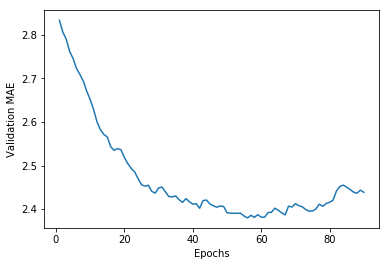

In [7]:
def smooth_curve(points, factor=0.9):
    
    smoothed_points = []
    
    for point in points:
        
        if smoothed_points:
        
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
            
        else:
            
            smoothed_points.append(point)
            
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Train final production model on all of the training samples

In [10]:
# A fresh model
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

Epoch 1/80
404/404 [==============================] - 0s 522us/step - loss: 469.0388 - mean_absolute_error: 19.7293
Epoch 2/80
404/404 [==============================] - 0s 157us/step - loss: 277.6530 - mean_absolute_error: 14.4980
Epoch 3/80
404/404 [==============================] - 0s 147us/step - loss: 125.0134 - mean_absolute_error: 8.8815
Epoch 4/80
404/404 [==============================] - 0s 154us/step - loss: 62.0079 - mean_absolute_error: 6.0249
Epoch 5/80
404/404 [==============================] - 0s 156us/step - loss: 37.4707 - mean_absolute_error: 4.6023
Epoch 6/80
404/404 [==============================] - 0s 163us/step - loss: 26.3360 - mean_absolute_error: 3.7312
Epoch 7/80
404/404 [==============================] - 0s 161us/step - loss: 20.7676 - mean_absolute_error: 3.1786
Epoch 8/80
404/404 [==============================] - 0s 159us/step - loss: 18.1381 - mean_absolute_error: 2.9655
Epoch 9/80
404/404 [==============================] - 0s 158us/step - loss: 16.7831

404/404 [==============================] - 0s 149us/step - loss: 6.3715 - mean_absolute_error: 1.7726
Epoch 73/80
404/404 [==============================] - 0s 142us/step - loss: 6.1660 - mean_absolute_error: 1.7458
Epoch 74/80
404/404 [==============================] - 0s 140us/step - loss: 6.3767 - mean_absolute_error: 1.7679
Epoch 75/80
404/404 [==============================] - 0s 149us/step - loss: 5.9722 - mean_absolute_error: 1.7035
Epoch 76/80
404/404 [==============================] - 0s 143us/step - loss: 6.2031 - mean_absolute_error: 1.7507
Epoch 77/80
404/404 [==============================] - 0s 143us/step - loss: 6.2138 - mean_absolute_error: 1.7356
Epoch 78/80
404/404 [==============================] - 0s 132us/step - loss: 6.0541 - mean_absolute_error: 1.7343
Epoch 79/80
404/404 [==============================] - 0s 152us/step - loss: 6.1245 - mean_absolute_error: 1.7662
Epoch 80/80
102/102 [==============================] - 0s 415us/step


3.024362227495979